# Introduction

Several computing tasks use models to represent and process available signals/data. One such a model applicable in multiple tasks is the sparsity of the underlying meaningful data.

In this notebook we propose to solve an image denoising problem given corrupted images. The data is intentionally constructed so as to adhere to the sparsity assumption.

By tackling this task using two fundamentally different algorithms, we evaluate how to solve such problems and illustrate the meaningfulness of our task.

The approaches implemented here cannot be directly applied on new data, as it will be clear soon. Nevertheless, it will provide us with some insights on which challenges have to be overcame in order to put such algorithms to do some real work.

## Acknowledgements and references

This material has been developed entirely based on content developed by **Michael Elad** and its brilliant team from the Computer-Science Department at The **Technion** (Israel). In case you are interested in more material on the topic, refeer to:

* Online course **Sparse Representation in Signal and image Processing: Fundamentals**, available on EdX;
* Reference book **Sparse and Redundant Representations**, by Michael Elad.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from omp import omp
from oracle import oracle
from bp_admm import bp_admm

from utils import *


Bad key text.latex.unicode in file /home/arthurt/anaconda3/envs/isp/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.frameon in file /home/arthurt/anaconda3/envs/isp/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 423 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key pgf.debug in file /home/arthurt/anaconda3/envs/isp/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 444 ('pgf.debug           : False')
You probably need to get an updated 

In [2]:
image_size = 40
dictionary_size = 2 * image_size ** 2
random_seed = 0

count_experiments = 5
gaussian_noise_sigma = 0.05
evaluated_cardinality = 10

count_displayed_experiments = 3

# Data representation

The starting point of our model is the representation of the our signal of interest (i.e. an image) $b \in R^n$ by a linear weight of other knwon images. The set of "generating images" is named the dictionary $\Phi \in R^{n, m}$, such that:

$$
b = \Phi \cdot x
$$

Hence, $x \in R^n$ is the weights vector, as you may guess. We can also interpret it as a **representation** vector, since it represents the sampled signal $b$ in the vector space defined by $\Phi$.

We will call each image (i.e. column) of $\Phi$ an atom, since we will built every other image from a subset of our dictionary atoms, just like the periodic table.

If each image had $n$ pixels, having $n$ linearly independent atoms would be enough for representing any possible $n$-pixel image. Nevertheless, having more atoms ($m>n$) is handful as it adds redundancy to the dictionary. Such redundancy favours our goal of finding the sparsest solution to our problem.

But what does **sparse** mean? For us, sparse will mean that most of the entries of our representation vector are zero.

## Dictionary creation

Having introduced the problem and its symbolism, its time to represent our data.

In [3]:
def construct_random_rectangle_image(image_size: int) -> np.ndarray:
        rectangle_width, rectangle_height = np.random.randint(5, 21, 2)
        x_top_left = np.random.randint(0, image_size - rectangle_width)
        y_top_left = np.random.randint(0, image_size - rectangle_height)

        rectangle_image = np.zeros((image_size, image_size))
        rectangle_image[y_top_left : y_top_left + rectangle_height,
                        x_top_left : x_top_left + rectangle_width ] = np.random.choice([-1,1])

        return rectangle_image

def construct_rectangles_dictionary(image_size, dictionary_size, random_seed: int = 0) -> np.ndarray:
    np.random.seed(random_seed)
    A = np.zeros((image_size**2, dictionary_size))

    for i in range(0, dictionary_size):
        candidate_accepted = False

        while not candidate_accepted:
            candidate = construct_random_rectangle_image(image_size).flatten()
            if (np.max(np.abs(candidate)) > 1e-4):
                candidate_accepted = True

        A[:, i] = candidate

    return normalize_columns_L2(A)

D, atoms_norms = construct_rectangles_dictionary(image_size, dictionary_size)

## Sample images

As stated previously, the data to be analyzed is supposed to be sparse in the representation domain. Our sparsity is corrupted by noise, though, which we shallremove later on.

In [4]:
np.random.seed(random_seed)
def construct_noisy_dataset(images_dictionary: np.ndarray, n_samples: int, gaussian_noise_sigma: float, data_cardinality: int):
    image_size, dict_size = np.shape(images_dictionary)

    dataset_sparse_domain = np.zeros((dict_size, n_samples))
    dataset_support = np.zeros((data_cardinality, n_samples), int)

    for i in range(0, n_samples):
        non_zero_locs = np.random.choice(range(0, dict_size), data_cardinality, replace=False)
        non_zero_locs.sort()
        non_zero_vals = np.random.normal(0, 1, data_cardinality)
        dataset_sparse_domain[non_zero_locs, i] = non_zero_vals
        dataset_support[:, i] = non_zero_locs

    dataset_clean_sampled = images_dictionary @ dataset_sparse_domain

    dynamic_range = np.abs(np.max(dataset_clean_sampled) - np.min(dataset_clean_sampled))
    noise_std = dynamic_range * gaussian_noise_sigma
    noise = np.random.randn(image_size, n_samples) * noise_std

    dataset_corrupted_sampled = dataset_clean_sampled + noise

    return dataset_sparse_domain, dataset_clean_sampled, dataset_corrupted_sampled, dataset_support


dataset_sparse_domain, dataset_clean_sampled, dataset_corrupted_sampled, dataset_support = construct_noisy_dataset(D, count_experiments, gaussian_noise_sigma, evaluated_cardinality)

PSNR_noisy = np.zeros((count_experiments))
for i in range(0, count_experiments):
    PSNR_noisy[i] = compute_psnr(dataset_clean_sampled, dataset_corrupted_sampled)

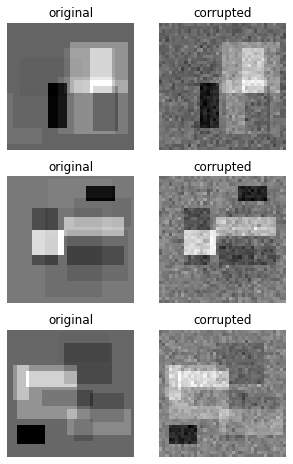

In [5]:
plt.figure(0, figsize=(5, 8))

for i in range(0, count_displayed_experiments):
    plt.subplot(count_displayed_experiments, 2, 2*i+1)
    plt.title('original')
    plt.axis('off')
    plt.imshow(dataset_clean_sampled[:, i].reshape(image_size, image_size), cmap='gray')

    plt.subplot(count_displayed_experiments, 2, 2*i+2)
    plt.title('corrupted')
    plt.axis('off')
    plt.imshow(dataset_corrupted_sampled[:, i].reshape(image_size, image_size), cmap='gray')

# Recovering the original signal

There exist several approaches for recovering the original signal from the noisy one. Each one of them will assume one specific mathematical modeling and recquire a set of informations about the data.

## Oracle prediction

The oracle has a precious information about the data: the support of original sparse representation, i.e. which atoms were used to build the corrupted data. It means that its job is not to find which atoms to use, but only their weights.

This can be accomplished by solving the minimaztion problem:

$$
x_0 = argmin_ x || A \cdot x - b || ^2, \text{ such that } b \in \text{support}_{x_{0}}
$$

In [6]:
PSNR_oracle = np.zeros(count_experiments)
predictions_representation_oracle = np.zeros_like(dataset_sparse_domain)
predictions_image_oracle = np.zeros_like(dataset_corrupted_sampled)

for i in range(0, count_experiments):
    corrupted_experiment = dataset_corrupted_sampled[:, i]
    clean_image = dataset_clean_sampled[:, i]
    experiment_support = dataset_support[:, i]

    x_oracle = oracle(D, corrupted_experiment, experiment_support)
    image_oracle = D @ x_oracle

    predictions_representation_oracle[:, i] = x_oracle
    predictions_image_oracle[:, i] = image_oracle
    PSNR_oracle[i] = compute_psnr(clean_image, image_oracle)

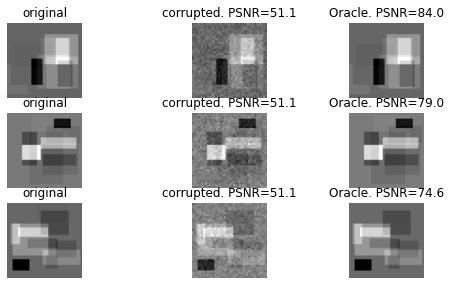

In [7]:
plt.figure(0, figsize=(8, 8))

for i in range(0, count_displayed_experiments):
    plt.subplot(count_experiments, 5, 5*i+1)
    plt.title('original')
    plt.axis('off')
    plt.imshow(dataset_clean_sampled[:, i].reshape(image_size, image_size), cmap='gray')

    plt.subplot(count_experiments, 3, 3*i+2)
    plt.title('corrupted. PSNR={:.1f}'.format(PSNR_noisy[i]))
    plt.axis('off')
    plt.imshow(dataset_corrupted_sampled[:, i].reshape(image_size, image_size), cmap='gray')

    plt.subplot(count_experiments, 3, 3*i+3)
    plt.title('Oracle. PSNR={:.1f}'.format(PSNR_oracle[i]))
    plt.axis('off')
    plt.imshow(predictions_image_oracle[:, i].reshape(image_size, image_size), cmap='gray')

# OMP Prediction

The Orthogonal Matching Pursuit (OMP) is a method for recovering the support, one atom at a time, until reaching a stop condition. As we are seeking sparse solutions, the stop condition must be related to it.

In this study, such condition is the maximum cardinality (i.e. number of non-zero entries) of the sparse representation support.

Compared to real applications, we are "cheating", since we use the clean image to evaluate which cardinality best solves our problem. Generally, the stop-condition is a problem by itself, so we will take this simplistic approach as a metter of didactics.

In [8]:
max_cardinality = min(2*evaluated_cardinality, dictionary_size)
PSNR_omp_per_cardinality = np.zeros((max_cardinality, count_experiments))
predictions_representation_omp = np.zeros_like(dataset_sparse_domain)
predictions_image_omp = np.zeros_like(dataset_corrupted_sampled)

for experiment in range(0, count_experiments):
    corrupted_experiment = dataset_corrupted_sampled[:, experiment]
    clean_image = dataset_clean_sampled[:, experiment]

    for cardinality_idx in range(0, max_cardinality):
        cardinality = cardinality_idx + 1
        x_omp = omp(D, corrupted_experiment, cardinality)
        image_omp = D @ x_omp

        curr_psnr = compute_psnr(clean_image, image_omp)
        PSNR_omp_per_cardinality[cardinality_idx, experiment] = curr_psnr
        if PSNR_omp_per_cardinality[cardinality_idx, experiment] == max(PSNR_omp_per_cardinality[:, experiment]) :
            best_image_omp = image_omp
            best_x_omp = x_omp

    predictions_representation_omp[:, experiment] = best_x_omp
    predictions_image_omp[:, experiment] = best_image_omp

PSNR_omp = np.max(PSNR_omp_per_cardinality, axis=0)

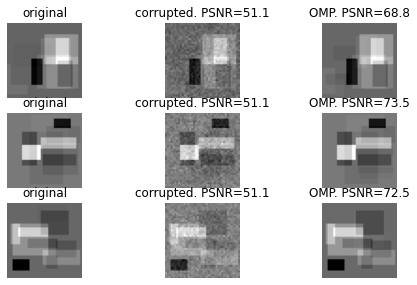

In [9]:
plt.figure(0, figsize=(8, 8))

for i in range(0, count_displayed_experiments):
    plt.subplot(count_experiments, 3, 3*i+1)
    plt.title('original')
    plt.axis('off')
    plt.imshow(dataset_clean_sampled[:, i].reshape(image_size, image_size), cmap='gray')

    plt.subplot(count_experiments, 3, 3*i+2)
    plt.title('corrupted. PSNR={:.1f}'.format(PSNR_noisy[i]))
    plt.axis('off')
    plt.imshow(dataset_corrupted_sampled[:, i].reshape(image_size, image_size), cmap='gray')

    plt.subplot(count_experiments, 3, 3*i+3)
    plt.title('OMP. PSNR={:.1f}'.format(PSNR_omp[i]))
    plt.axis('off')
    plt.imshow(predictions_image_omp[:, i].reshape(image_size, image_size), cmap='gray')

After checking that our algorithm works, let's grasp some insights for future studies. In the image below, one can see the evolution of PSNR w.r.t. evaluated cardinality for all evaluated experiments.

Text(0, 0.5, 'PSNR')

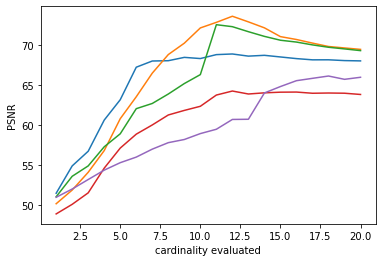

In [10]:
plt.plot(np.linspace(1, max_cardinality, max_cardinality), PSNR_omp_per_cardinality)
plt.xlabel('cardinality evaluated')
plt.ylabel('PSNR')

Generally speaking, before the true cardinality we observe a linear-ish improvement on PSNR. It is followed by a knee close to the true cardinality, and by a quasi-static line afterwards, indicating that adding new atoms do not improve our representation anymore.

Does it give you any insights on candidate approaches for applying OMP to cases where no truth image is available?

# BP-ADMM

Basis Pursuit uses a different approach, as it intends to solve a strict definition of the sparse problem:

$$
x_0 = argmin_x ||x||_0 \text{ such that } || b - \Phi \cdot x||_2 < \epsilon
$$

Where $||x||_0$ is the true measurement of sparsity (i.e. count of non-zero elements), and $\epsilon$ is a small acceptable error.

As this problem is way too hard to solve, the Basis Pursuit takes an approximate approach, and actually solves a somehow easier mathematical problem. It simply replaces the L-0 by the L-1 norm:

$$
x_0 = argmin_x ||x||_1 \text{ such that } || b - \Phi \cdot x ||_2 < \epsilon
$$

This BP is actually solved by another method, the Alternatig Direction Method of Multipliers (ADMM). We refeer to the aformentioned textbook for further details on ADMM. We notice only that ADMM has a single hyperparameter $\lambda$ which have to be tuned. We adopt a brute force approach here for evaluating $\lambda$ that optimizes our goal.

In [11]:
# sweep over various values of lambda
num_lambda_values = 10
PSNR_admm_per_lambda = np.zeros((num_lambda_values, count_experiments))
predictions_representation_bpadmm = np.zeros_like(dataset_sparse_domain)
predictions_image_bpadmm = np.zeros_like(dataset_corrupted_sampled)

for experiment in range(0, count_experiments):
    corrupted_experiment = dataset_corrupted_sampled[:, experiment]
    clean_image = dataset_clean_sampled[:, experiment]

    # Run the BP for various values of lambda and pick the best result
    lambda_max = np.linalg.norm(D.T @ corrupted_experiment, np.inf)
    lambda_vec = np.logspace(-5,0,num_lambda_values)*lambda_max

    # Loop over various values of lambda
    for lambda_ind in range(num_lambda_values):
        x_admm = bp_admm(D, corrupted_experiment, lambda_vec[lambda_ind], tol_admm=5e-3)
        b_admm = D @ x_admm

        PSNR_admm_per_lambda[lambda_ind, experiment] = compute_psnr(clean_image, b_admm)

        if PSNR_admm_per_lambda[lambda_ind, experiment] == max(PSNR_admm_per_lambda[:, experiment]) :
            best_b_admm = b_admm
            best_x_admm = x_admm

        # print some statistics
        print('BP experiment %d/%d, lambda %d/%d, PSNR %.3f' % \
              (experiment+1,count_experiments,lambda_ind+1,num_lambda_values,PSNR_admm_per_lambda[lambda_ind, experiment]))

    # Save the best PSNR
    predictions_representation_bpadmm[:, experiment] = best_x_admm
    predictions_image_bpadmm[:, experiment] = best_b_admm
    PSNR_admm = np.max(PSNR_admm_per_lambda, axis=0)


BP experiment 1/5, lambda 1/10, PSNR 58.975
BP experiment 1/5, lambda 2/10, PSNR 59.111
BP experiment 1/5, lambda 3/10, PSNR 59.529
BP experiment 1/5, lambda 4/10, PSNR 60.763
BP experiment 1/5, lambda 5/10, PSNR 63.511
BP experiment 1/5, lambda 6/10, PSNR 68.077
BP experiment 1/5, lambda 7/10, PSNR 68.577
BP experiment 1/5, lambda 8/10, PSNR 59.315
BP experiment 1/5, lambda 9/10, PSNR 52.029
Exiting, but BP-ADMM did not converge
BP experiment 1/5, lambda 10/10, PSNR 47.298
BP experiment 2/5, lambda 1/10, PSNR 58.754
BP experiment 2/5, lambda 2/10, PSNR 58.840
BP experiment 2/5, lambda 3/10, PSNR 59.115
BP experiment 2/5, lambda 4/10, PSNR 59.957
BP experiment 2/5, lambda 5/10, PSNR 62.018
BP experiment 2/5, lambda 6/10, PSNR 66.063
BP experiment 2/5, lambda 7/10, PSNR 70.512
BP experiment 2/5, lambda 8/10, PSNR 60.411
BP experiment 2/5, lambda 9/10, PSNR 53.112
Exiting, but BP-ADMM did not converge
BP experiment 2/5, lambda 10/10, PSNR 48.428
BP experiment 3/5, lambda 1/10, PSNR 59.37

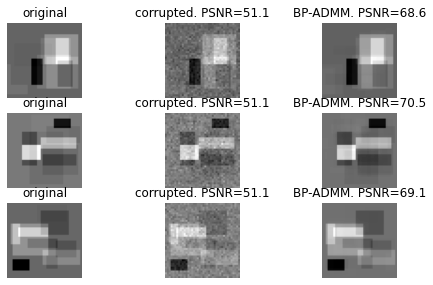

In [12]:
plt.figure(0, figsize=(8, 8))

for i in range(0, count_displayed_experiments):
    plt.subplot(count_experiments, 3, 3*i+1)
    plt.title('original')
    plt.axis('off')
    plt.imshow(dataset_clean_sampled[:, i].reshape(image_size, image_size), cmap='gray')

    plt.subplot(count_experiments, 3, 3*i+2)
    plt.title('corrupted. PSNR={:.1f}'.format(PSNR_noisy[i]))
    plt.axis('off')
    plt.imshow(dataset_corrupted_sampled[:, i].reshape(image_size, image_size), cmap='gray')

    plt.subplot(count_experiments, 3, 3*i+3)
    plt.title('BP-ADMM. PSNR={:.1f}'.format(PSNR_admm[i]))
    plt.axis('off')
    plt.imshow(predictions_image_bpadmm[:, i].reshape(image_size, image_size), cmap='gray')

Text(0, 0.5, 'PSNR')

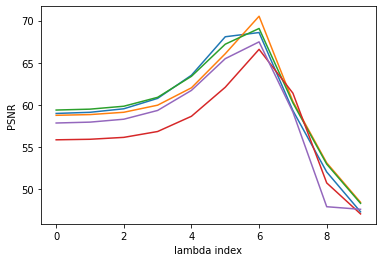

In [13]:
plt.plot(PSNR_admm_per_lambda)
plt.xlabel('lambda index')
plt.ylabel('PSNR')

From this experiment we have a strong indication that there exist a value (or range of values) that provides us with an optimal solution for our problem.

# Final considerations

Both OMP and BP-ADMM have managed to achieve satisfatory recover of the original sparse representation, in spite of noise corruption. A brief comparison is presented bellow.

This indicates that, provided adequate stop conditions and dictionary, they may be able to handle the denoising recovery task based on sparse model assumption.

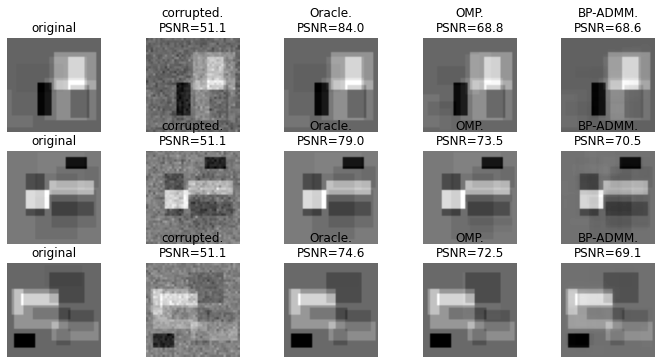

In [14]:
plt.figure(0, figsize=(12, 10))

for i in range(0, count_displayed_experiments):
    plt.subplot(count_experiments, 5, 5*i+1)
    plt.title('original')
    plt.axis('off')
    plt.imshow(dataset_clean_sampled[:, i].reshape(image_size, image_size), cmap='gray')

    plt.subplot(count_experiments, 5, 5*i+2)
    plt.title('corrupted.\nPSNR={:.1f}'.format(PSNR_noisy[i]))
    plt.axis('off')
    plt.imshow(dataset_corrupted_sampled[:, i].reshape(image_size, image_size), cmap='gray')

    plt.subplot(count_experiments, 5, 5*i+3)
    plt.title('Oracle.\nPSNR={:.1f}'.format(PSNR_oracle[i]))
    plt.axis('off')
    plt.imshow(predictions_image_oracle[:, i].reshape(image_size, image_size), cmap='gray')

    plt.subplot(count_experiments, 5, 5*i+4)
    plt.title('OMP.\nPSNR={:.1f}'.format(PSNR_omp[i]))
    plt.axis('off')
    plt.imshow(predictions_image_omp[:, i].reshape(image_size, image_size), cmap='gray')

    plt.subplot(count_experiments, 5, 5*i+5)
    plt.title('BP-ADMM.\nPSNR={:.1f}'.format(PSNR_admm[i]))
    plt.axis('off')
    plt.imshow(predictions_image_bpadmm[:, i].reshape(image_size, image_size), cmap='gray')